# 第三次讀書會報告-word2vec

組別:第9組

Date:2024/05/07

# 1.載入環境及安裝套件

In [18]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
import jieba
import jieba.analyse

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")

In [19]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

#圖型相關設定
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120

# 2.資料前處理

## 2.1資料蒐集
本小組自Tarflow下載Dacrd上旅遊個版主題三個時間區段的文章資料集，並執行程式合成完整的2024年3月份Dacrd旅遊版資料集，共2,654筆資料。

其內容包含system_id、ataSource、artUrl、artDate、artTitle、artContent、boardID(文章所屬個版)、
commentCount(評論次數)、department、gender、school等欄位。

Data includes:
*   Dcard文章 from 2024/03/01 - 2024/03/30
*   三個時間區段分別為：
*   2024/03/01 - 2024/03/10
*   2024/03/11 - 2024/03/20
*   2024/03/21 - 2024/03/30
*   因資料集爬取數量限制，故才分為三個區段蒐集。

資料來源:https://tarflow.mis.nsysu.edu.tw/login?next=%2Fmain%2F662d88ed73

## 2.2資料匯入與斷詞

In [21]:
# 設定繁體中文詞庫
jieba.set_dictionary('./study_group9_3/dict/dict.txt.big')

# 新增stopwords
with open('./study_group9_3/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [22]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [23]:
##讀取資料集
dcard_travel_df = pd.read_csv("./2024_study_group9_3/raw_data/dcard_dataset/dcard_travel_df.csv")
dcard_travel_df

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,travel,2,romypan08,F,romii
1,2,Dcard,https://www.dcard.tw/f/travel/p/254851165,2024-03-02 14:29:53,#其他 香港天際100門票,上次去香港未使用到\n在此有兩張香港天際100甜甜優惠門票，可私訊～\n有效期3/31！！\...,travel,0,paopaosister,F,tttinggg
2,3,Dcard,https://www.dcard.tw/f/travel/p/254850600,2024-03-02 13:38:43,#國內遊記 2024台南高鐵燈會\n超大又好逛好看\n精彩程度真的很用心\n\n燈會期間：2...,2024世界蘭展在歸仁大台南會展中心展出 \n事先買了後壁國際蘭展和歸仁世界蘭展雙展預售票 ...,travel,0,candy10068,F,不4小哭包 (@)
3,4,Dcard,https://www.dcard.tw/f/travel/p/254846205,2024-03-02 05:57:32,#國外遊記 （售）去日本的大家～有需要ESIM的嗎🥺,因為自己幫家人買ESIM FUN\n8 天 - 吃到飽（每天2GB）用完降速不斷網方案\n\...,travel,1,NaN,F,國立臺中科技大學
4,5,Dcard,https://www.dcard.tw/f/travel/p/254833534,2024-03-01 00:34:34,#請益 訊問 遊瑞士推薦旅社,大家好，\n今年4～6月想安排與家人一起去瑞士旅遊，想詢問一下大家有沒有比較推薦的旅行社？\...,travel,7,clairechou55,F,claire
...,...,...,...,...,...,...,...,...,...,...,...
2649,935,Dcard,https://www.dcard.tw/f/travel/p/255036982,2024-03-21 08:38:30,#請益 澳洲旅遊,最近有計劃一個人去澳洲玩，但我英文不太行🥲，大家推薦旅遊團還是自由行呢～,travel,4,meownisohot,F,mini
2650,936,Dcard,https://www.dcard.tw/f/travel/p/255036751,2024-03-21 08:12:37,#國外遊記 2024 3月份中國自由行上海蘇州三天兩夜分享-遊記心得篇,以下都是我旅遊過程中的隨手紀錄ＸＤ可能沒什麼邏輯但就是留個紀念～\n\n好久沒搭大客機了（3...,travel,3,apple.oh.banana,F,大魚小魚魚片粥
2651,937,Dcard,https://www.dcard.tw/f/travel/p/255036691,2024-03-21 08:05:45,#其他 #蜜月揪團分享 113/06/11義大利蜜月,⭐️揪團（目前還有早鳥優惠6000元/人!)\n『菁選旅行社』幸福夏季華航義大利15日\n日...,travel,1,NaN,F,國立彰化師範大學
2652,938,Dcard,https://www.dcard.tw/f/travel/p/255036774,2024-03-21 08:15:16,#徵旅伴 4/3 巴黎迪士尼,大家好٩(˃̶͈̀௰˂̶͈́)و\n來問問看有沒有人4/3想一起去巴黎迪士尼玩\n\n3/2...,travel,3,bcm,F,妃奈⋆⸜ ෆ ⸝‍⋆


In [26]:
# 資料前處理

# 去除一些不需要的欄位
metaData = dcard_travel_df.drop(['dataSource', 'boardID', 'commentCount', 'department', 'gender', 'school'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

#sentence型態轉換成str，避免資料清理出現error
metaData['sentence'] = (metaData['sentence'].astype(str))
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from /Users/billyke/2024week11/dict/dict.txt.big ...
2024-05-05 15:53:00,777 : DEBUG : Building prefix dict from /Users/billyke/2024week11/dict/dict.txt.big ...
Loading model from cache /var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/jieba.u017fbf9098c6ac919ec24664982d9ee5.cache
2024-05-05 15:53:00,778 : DEBUG : Loading model from cache /var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/jieba.u017fbf9098c6ac919ec24664982d9ee5.cache
Loading model cost 0.490 seconds.
2024-05-05 15:53:01,268 : DEBUG : Loading model cost 0.490 seconds.
Prefix dict has been built successfully.
2024-05-05 15:53:01,269 : DEBUG : Prefix dict has been built successfully.


,system_id,artUrl,artDate,artTitle,artContent,sentence,word
0,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,在西雅圖參加研討會,"[西雅圖, 參加, 研討會]"
1,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,臨時有個空檔,"[臨時, 有個, 空檔]"
2,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,想安排個大自然行程,"[安排, 大自然, 行程]"
3,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,打算用的一日遊,"[打算, 一日遊]"
4,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,可以從西雅圖市區出發,"[西雅圖, 市區, 出發]"
...,...,...,...,...,...,...,...
57469,938,https://www.dcard.tw/f/travel/p/255036774,2024-03-21 08:15:16,#徵旅伴 4/3 巴黎迪士尼,大家好٩(˃̶͈̀௰˂̶͈́)و\n來問問看有沒有人4/3想一起去巴黎迪士尼玩\n\n3/2...,我應該算好相處自由行大約個國家獨旅五次左右不會是個雷包旅伴也謝絕雷包希望是至少能照顧好自己的...,"[算好, 相處, 自由, 國家, 獨旅, 五次, 雷包, 旅伴, 謝絕, 雷包, 希望, 至..."
57470,938,https://www.dcard.tw/f/travel/p/255036774,2024-03-21 08:15:16,#徵旅伴 4/3 巴黎迪士尼,大家好٩(˃̶͈̀௰˂̶͈́)و\n來問問看有沒有人4/3想一起去巴黎迪士尼玩\n\n3/2...,有意願請私訊,"[意願, 私訊]"
57471,939,https://www.dcard.tw/f/travel/p/255036890,2024-03-21 08:29:37,#請益 有人因為出國旅行腳發炎的嗎?,前一陣子跟朋友去日本自由行~\n走了很多路之後腳的內側一直痛到現在\n去看復健科醫師說是肌腱...,前一陣子跟朋友去日本自由行走了很多路之後腳的內側一直痛到現在去看復健科醫師說是肌腱發炎了有開...,"[前一陣子, 朋友, 日本, 自由, 行走, 內側, 痛到, 復健, 醫師, 肌腱, 發炎,..."
57472,939,https://www.dcard.tw/f/travel/p/255036890,2024-03-21 08:29:37,#請益 有人因為出國旅行腳發炎的嗎?,前一陣子跟朋友去日本自由行~\n走了很多路之後腳的內側一直痛到現在\n去看復健科醫師說是肌腱...,另外如果做了這種鞋墊如果是你會穿著出國嗎,"[鞋墊, 穿著, 出國]"


# 3.word2vec

將word2vec實際運用在資料集上

In [27]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

2024-05-05 15:56:06,579 : INFO : collecting all words and their counts
2024-05-05 15:56:06,586 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2024-05-05 15:56:06,627 : INFO : PROGRESS: at sentence #10000, processed 47933 words and 48643 word types
2024-05-05 15:56:06,657 : INFO : PROGRESS: at sentence #20000, processed 93905 words and 86129 word types
2024-05-05 15:56:06,682 : INFO : PROGRESS: at sentence #30000, processed 137691 words and 119455 word types
2024-05-05 15:56:06,708 : INFO : PROGRESS: at sentence #40000, processed 182168 words and 151083 word types
2024-05-05 15:56:06,738 : INFO : PROGRESS: at sentence #50000, processed 230772 words and 186126 word types
2024-05-05 15:56:06,746 : INFO : collected 194472 token types (unigram + bigrams) from a corpus of 243134 words and 52525 sentences
2024-05-05 15:56:06,746 : INFO : merged Phrases<194472 vocab, min_count=1, threshold=1000, max_vocab_size=40000000>
2024-05-05 15:56:06,747 : INFO : Phrases lifecycle 

,system_id,artUrl,artDate,artTitle,artContent,sentence,word,word_list_bigrams
0,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,在西雅圖參加研討會,"[西雅圖, 參加, 研討會]","[西雅圖, 參加, 研討會]"
1,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,臨時有個空檔,"[臨時, 有個, 空檔]","[臨時, 有個, 空檔]"
2,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,想安排個大自然行程,"[安排, 大自然, 行程]","[安排, 大自然, 行程]"
3,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,打算用的一日遊,"[打算, 一日遊]","[打算, 一日遊]"
4,1,https://www.dcard.tw/f/travel/p/254834805,2024-03-01 03:44:19,#徵旅伴 #徵3/9旅伴 西雅圖奧林匹克國家公園,在西雅圖參加研討會，臨時有個空檔，想安排個大自然行程，打算用klook的一日遊，可以從西雅圖...,可以從西雅圖市區出發,"[西雅圖, 市區, 出發]","[西雅圖, 市區, 出發]"


In [28]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [29]:
#列出經常出現的詞彙
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 38482


['真的', '行程', '時間', '飯店', '機場', '推薦', '好吃', '朋友', '分享', '旅遊']

In [30]:
#列出sentence相關資訊
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 52525
average length of sentences: 4.49726796763446


In [31]:
# 環境變數設定
%env PYTHONHASHSEED=8787

# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

env: PYTHONHASHSEED=8787
number of cores: 10


In [32]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

2024-05-05 15:57:38,886 : INFO : collecting all words and their counts
2024-05-05 15:57:38,890 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-05-05 15:57:38,902 : INFO : PROGRESS: at sentence #10000, processed 46701 words, keeping 14025 word types
2024-05-05 15:57:38,910 : INFO : PROGRESS: at sentence #20000, processed 91255 words, keeping 21512 word types
2024-05-05 15:57:38,917 : INFO : PROGRESS: at sentence #30000, processed 133854 words, keeping 27361 word types
2024-05-05 15:57:38,925 : INFO : PROGRESS: at sentence #40000, processed 177009 words, keeping 32267 word types
2024-05-05 15:57:38,933 : INFO : PROGRESS: at sentence #50000, processed 224279 words, keeping 37286 word types
2024-05-05 15:57:38,935 : INFO : collected 38482 word types from a corpus of 236219 raw words and 52525 sentences
2024-05-05 15:57:38,936 : INFO : Creating a fresh vocabulary
2024-05-05 15:57:38,947 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=30 retains

In [33]:
#檢查最相關的字
w2v_model.wv.most_similar('好吃',topn=10)

[('超級', 0.9595080018043518),
 ('口味', 0.9354578852653503),
 ('真的', 0.927868664264679),
 ('可愛', 0.9068743586540222),
 ('味道', 0.9058440923690796),
 ('東西', 0.9051952362060547),
 ('感覺', 0.8869349360466003),
 ('好喝', 0.8860219120979309),
 ('食物', 0.8727726340293884),
 ('起司', 0.8672266602516174)]

此處可看出在2024年3月期間，Dcard旅遊版上提到好吃的東西，起司會是最常出現的

In [34]:
w2v_model.wv.most_similar('旅遊',topn=20)

[('自由', 0.9692856073379517),
 ('旅行', 0.9612826704978943),
 ('歐洲', 0.9567610025405884),
 ('跟團', 0.9491724371910095),
 ('獨旅', 0.9482667446136475),
 ('參加', 0.9429598450660706),
 ('想要', 0.942560076713562),
 ('經驗', 0.9420669674873352),
 ('晴天', 0.9334092736244202),
 ('去過', 0.9316201210021973),
 ('謝謝', 0.9236712455749512),
 ('分享', 0.9232989549636841),
 ('出國', 0.9209865927696228),
 ('自助', 0.9206959009170532),
 ('聊聊', 0.9171602129936218),
 ('去年', 0.9150640368461609),
 ('留言', 0.9149388074874878),
 ('泰國', 0.9144177436828613),
 ('參考', 0.9134445190429688),
 ('規劃', 0.9132288694381714)]

此處可看出在此期間，最常被討論旅遊的國家為歐洲、泰國，經研究發現與近期歐洲旅遊價鉻下降有所關聯，同時也可看出大多數討論者傾向自由旅行、自己規劃行程

In [35]:
w2v_model.wv.most_similar(['飯店','推薦'],topn=10)

[('京都', 0.8994706273078918),
 ('民宿', 0.8931934237480164),
 ('整理', 0.8890011310577393),
 ('出門', 0.8882712721824646),
 ('評價', 0.8878567218780518),
 ('簡單', 0.8806538581848145),
 ('兩間', 0.8799856305122375),
 ('青旅', 0.8766645193099976),
 ('吐司', 0.8761585354804993),
 ('休息', 0.8756968975067139)]

此處可看出在此期間日本京都也受到討論、尤其是推薦飯店，比較特別的是吐司可能因為比較普及，可能經常出現在飯店的早點中，
民宿跟青旅也常會搭配吐司早餐，也有可能討論者相對窮苦，更喜歡便利性、金錢負擔較小的食物，吐司才會被廣泛討論。

In [36]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['機場','旅遊'],topn=10)

[('好吃', -0.25854790210723877),
 ('超級', -0.3120507597923279),
 ('真的', -0.33637773990631104),
 ('版本_觀看', -0.3897082507610321),
 ('可愛', -0.40249577164649963),
 ('口味', -0.4366786777973175),
 ('喜歡', -0.4490582346916199),
 ('感覺', -0.4674249291419983),
 ('完整', -0.48552051186561584),
 ('更新_最新', -0.5016663670539856)]

In [37]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("行程","飯店")

0.43488625

In [38]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("飯店","京都")

0.8684337

In [39]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["飯店", "機場", '好吃'])

'好吃'

In [40]:
# 相對關係
w2v_model.wv.most_similar(positive=["飯店"], negative=["機場"], topn=5)

[('美食', 0.39006665349006653),
 ('餐廳', 0.3727167248725891),
 ('景點', 0.33599865436553955),
 ('喜歡', 0.32975488901138306),
 ('早餐', 0.3285365402698517)]

In [41]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()
words

dict_keys(['真的', '行程', '時間', '飯店', '機場', '推薦', '好吃', '朋友', '分享', '旅遊', '地方', '台灣', '喜歡', '日本', '希望', '住宿', '拍照', '體驗', '景點', '晚上', '感覺', '小時', '前往', '選擇', '請問', '分鐘', '有沒有', '香港', '行李', '超級', '東西', '發現', '建議', '有人', '機票', '便宜', '第一次', '出發', '謝謝', '飛機', '韓國', '價格', '餐廳', '特別', '出國', '不錯', '旅行', '早餐', '安排', '房間', '旅伴', '興趣', '抵達', '晚餐', '旁邊', '照片', '兩個', '台幣', '提供', '自由', '原本', '討論', '地點', '排隊', '想要', '女生', '旅行社', '經驗', '酒店', '可愛', '詢問', '天氣', '活動', '只能', '搭乘', '導遊', '交通', '當天', '預計', '結束', '服務', '門票', '泰國', '預約', '免費', '護照', '航空', '迪士尼', '東京', '介紹', '午餐', '手機', '國家', '找到', '休息', '購買', '去過', '中國', '記得', '適合', '市區', '巴士', '日期', '下午', '私訊', '辦法', '民宿', '美食', '資訊', '現場', '這是', '網路', '離開', '口味', '費用', '早上', '市場', '店家', '歐洲', '方式', '地鐵', '行李箱', '博物館', '規劃', '味道', '來回', '越南', '幫忙', '英文', '食物', '車站', '咖啡', '回到', '公園', '店員', '幾天', '回程', '澳門', '纜車', '轉機', '空間', '文章', '入住', '世界', '外面', '工作', '參加', '旅程', '舒服', '風景', '回來', '網路上', '人員', '設施', '路上', '司機', '整體', '感謝', '路線', '想問', '超市', '人數', '值得', '參觀'

#### 視覺化字之間的關係及將字做分群

「維度降低」是個數學代數上的一個抽象概念，簡略地說，一個多維度空間裏的函數（例如4個維度），

我們可經由對該函數結構推理，將該高維度的函數壓縮映射投影至一個較低維度的空間裏（例如2個維度），

在這個較低維度的子空間裏，仍依然保有原高維度函數的大多數結構資訊，我們即可利用這個低維度的替身，來探索較複雜的高維度本尊的結構特性。

In [43]:
# 降維：利用PCA tSNE
def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

「維度降低」在機器學習領域上的運用優點

1.提高模型運算效能

機器學習模型運算是需要資源的，當我們將高維度的數據集壓縮到一個較小的維度裏時，這意味著我們需要計算的東西變少了，

相對應的資源耗費當然也變少了，可提高模型的運算效能。

2.「維度降低」利於數據集的視覺化呈現

由於我們至多只能在3維的空間裏展現視覺圖形，4個維度以上的數據集，很難以一目瞭然的方式將其視覺化。

但我們若能將高維度的數據集壓縮至3個維度以內的子空間內，我們即可在這個低維度的子空間內視覺化數據集的結構特點。

In [78]:
# 拿到list of words 的vector，此部分為建立函式來取出向量供後續研究
def getVecs(model,words:list,size):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [80]:
getVecs(w2v_model,['旅遊','飯店'])

array([[ 0.12424906,  0.00326962, -0.28323138,  0.35406166,  0.44035432,
         0.0899886 ,  0.13827442,  0.15261371, -0.21883437,  0.11738303,
         0.25612488, -0.22664182, -0.02105232,  0.06129333, -0.11687581,
         0.36603695,  0.35336766, -0.05231683, -0.16912438, -0.04673148,
         0.10311257,  0.08671751,  0.00561802,  0.18158364, -0.3264442 ,
         0.16186152,  0.07742244,  0.12289206,  0.19218552, -0.12064094,
         0.2582567 ,  0.33965978, -0.13569269, -0.07470034, -0.14280997,
        -0.2849171 ,  0.05814195, -0.5133929 , -0.19198845,  0.21352999,
        -0.09755664, -0.09913509,  0.18542358,  0.4291913 , -0.12575758,
        -0.09720144,  0.03643473,  0.30323344,  0.13873272, -0.40066415,
         0.67177814, -0.12553732, -0.17893778,  0.10483289, -0.04393546,
        -0.23366302, -0.12960179, -0.08382405,  0.24353772, -0.04739381,
         0.2692543 , -0.06165248,  0.09583279,  0.12925325, -0.2000766 ,
        -0.01821354, -0.15287526,  0.14471902,  0.0

In [81]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))

In [82]:
expandPosWord(w2v_model,['旅遊','夜景'],top_n = 10)

['自由',
 '樓梯',
 '一條',
 '晴天',
 '電視',
 '造型',
 '販售',
 '外帶',
 '高級',
 '經驗',
 '旅行',
 '海邊',
 '歐洲',
 '欣賞',
 '去過',
 '參加',
 '裡的',
 '獨旅',
 '跟團',
 '想要']

此擴充字詞中提到包含海邊、歐洲、晴天等，也顯示出討論者渴望的夜景可能出現的地方或因素。

In [83]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./2024_study_group9_3/TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [84]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words,size='3')
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [85]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

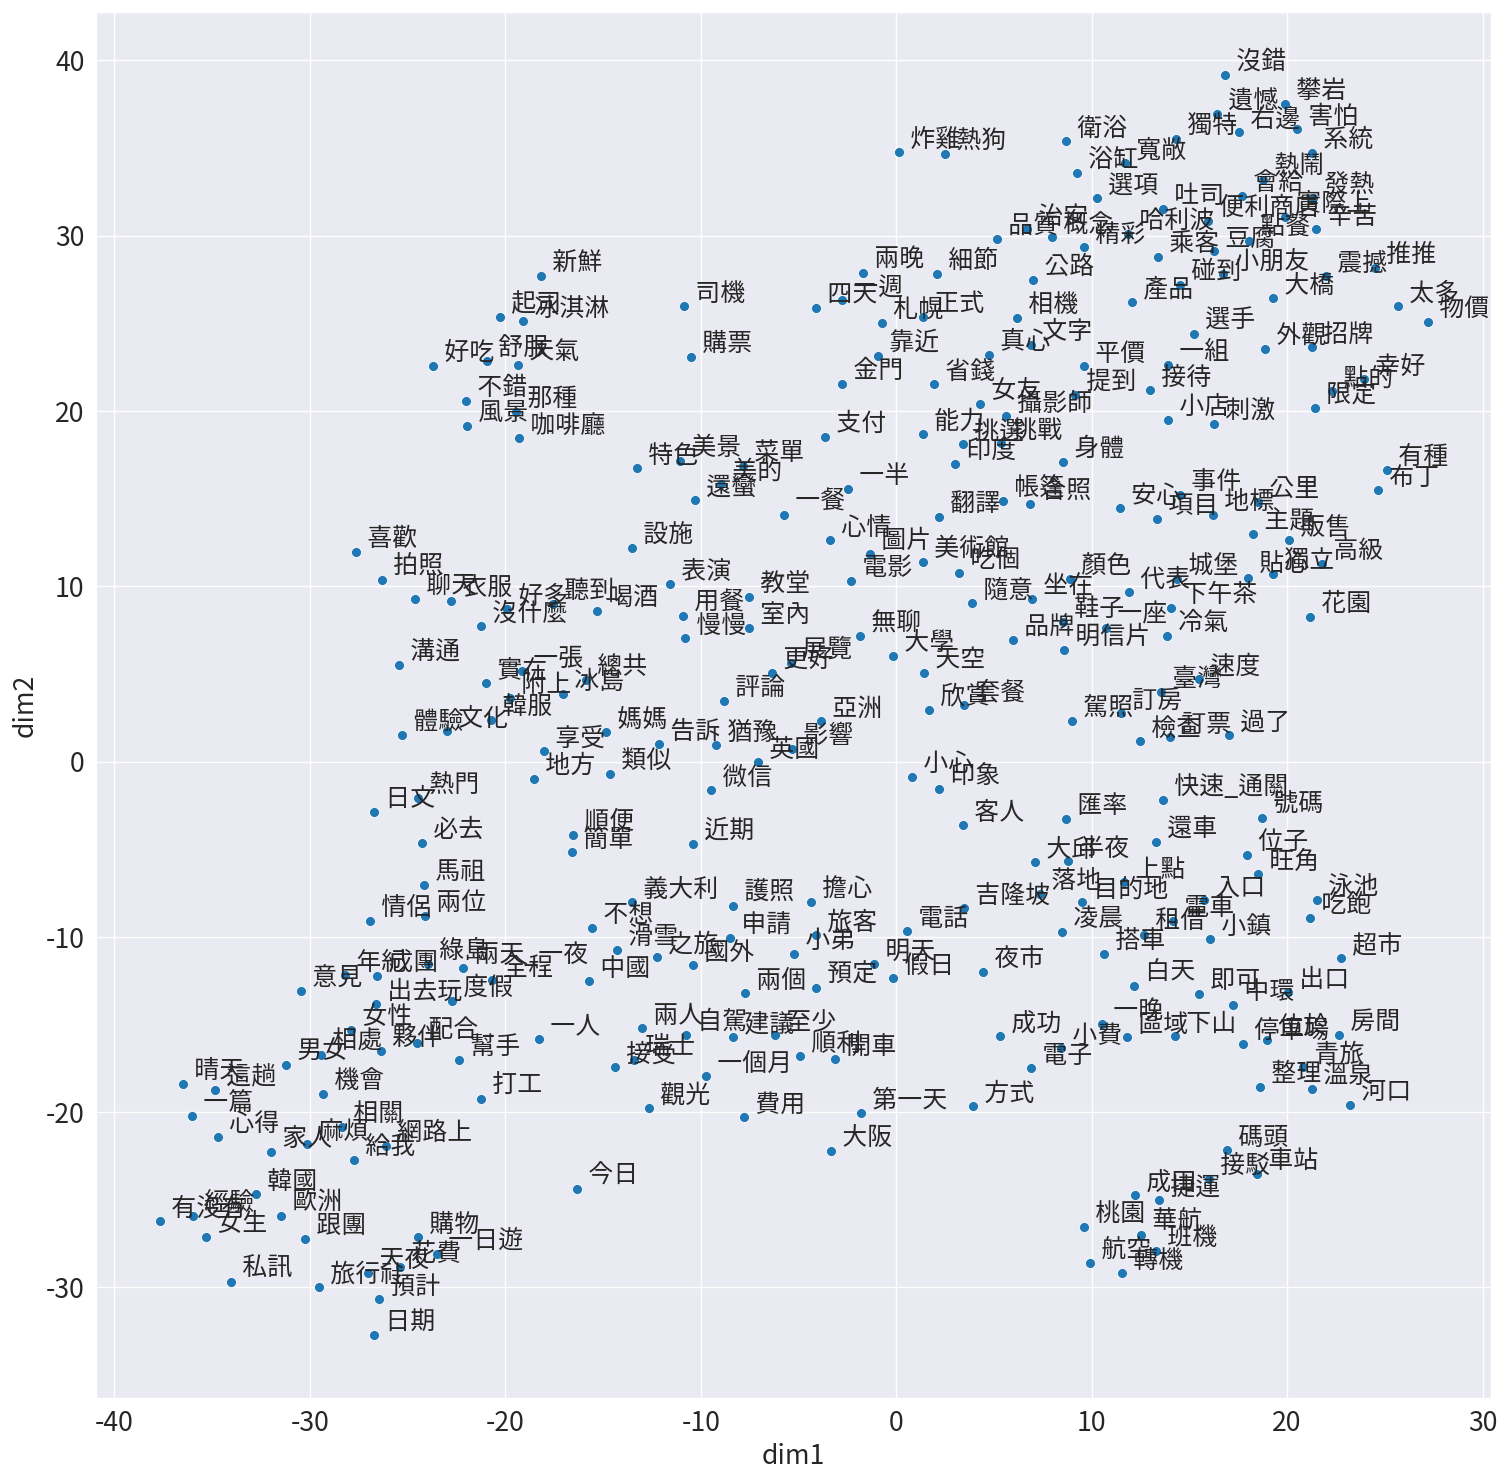

In [86]:
#兩維的散佈圖
plotScatter(word_df)

由此可看出字詞間的關聯性，像是上面提及的吐司，就跟便利商店鄰近，可能情形像是學生住青旅或是為了省錢，而去便利商店購買吐司當早餐。
或是像去韓國、歐洲，可能選擇跟團的人就會比較多。

(300, 20)


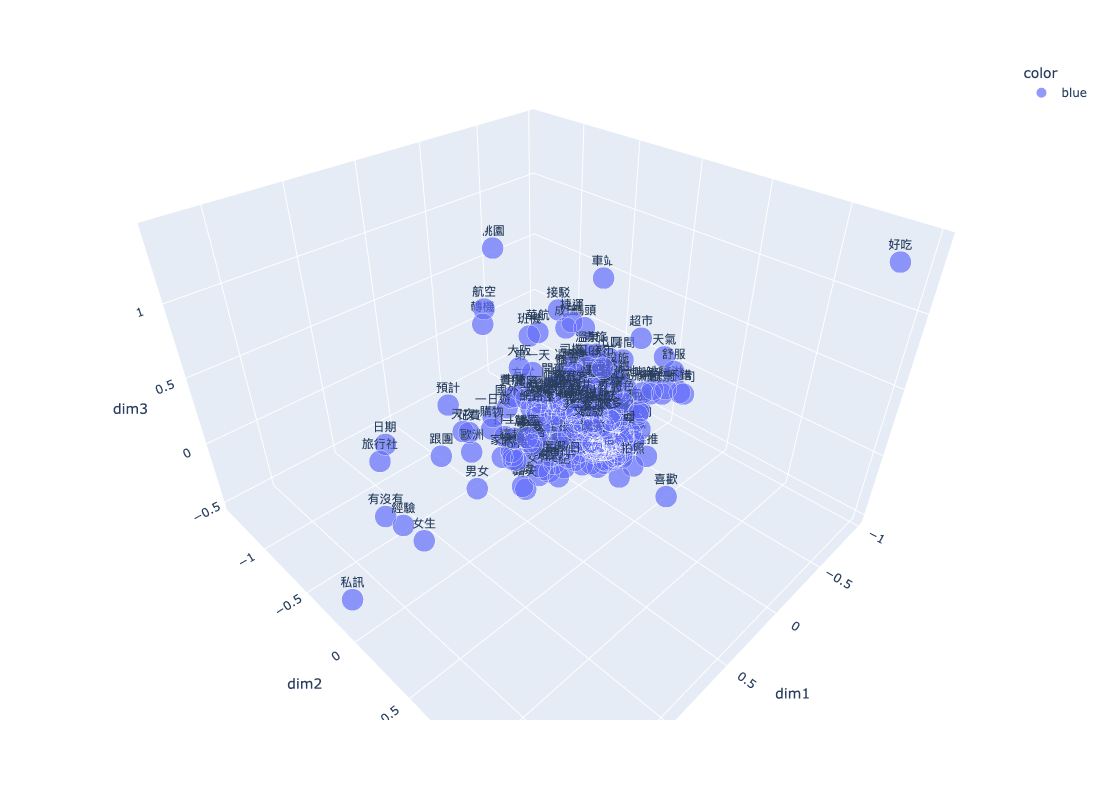

In [90]:
#三D散狀圖
ew_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
new_word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(new_word_df)

In [88]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群，透過文字向量來進行分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

/opt/anaconda3/envs/SMA2024env/lib/python3.9/site-packages/sklearn_extra/cluster/_commonnn.py:18: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/opt/anaconda3/envs/SMA2024env/lib/python3.9/site-packages/sklearn_extra/cluster/_commonnn.py:18: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



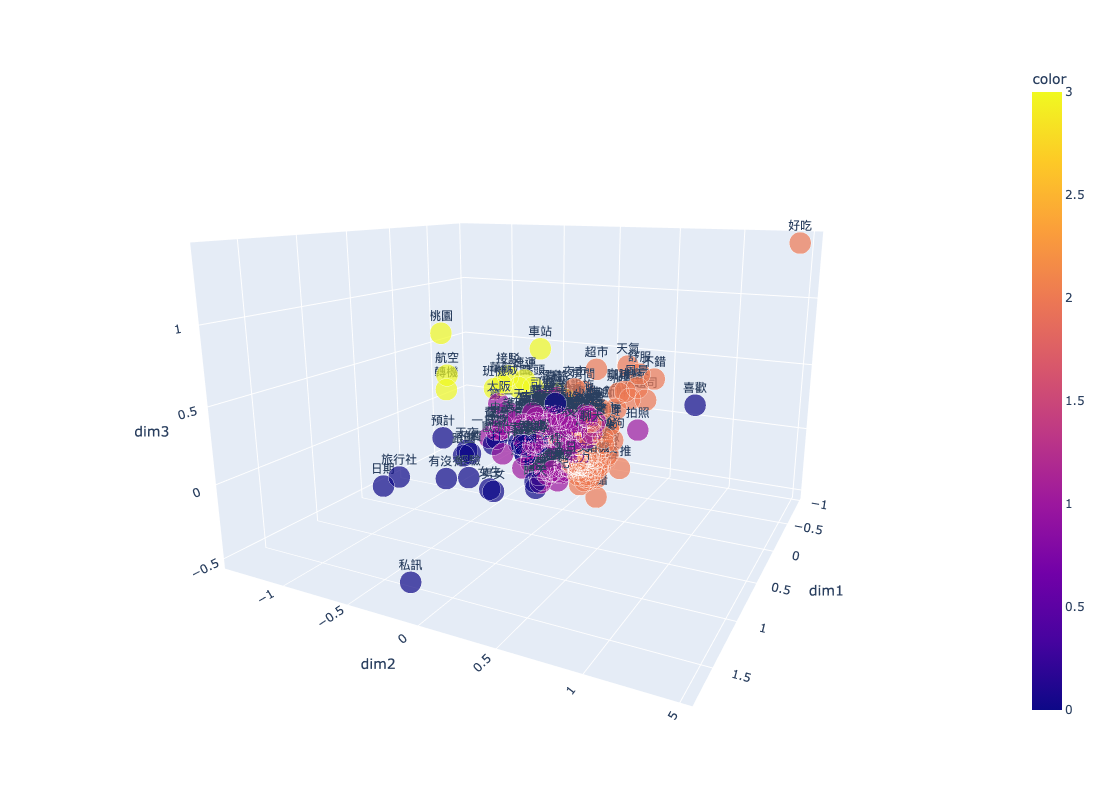

In [89]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
#繪製三D散狀圖
plotScatter3D(word_df)

以上透過不同方式來呈現降維後產生的結果